In [18]:
import sys
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

sys.path.insert(0, os.path.abspath('..'))
from src.portfolio_creation import create_portfolio_returns, calculate_performance_metrics

In [19]:
# Read in data
PROJECT_ROOT = Path.cwd().parent  # assuming notebook is in ./notebooks/
DATA_DIR = PROJECT_ROOT / "data"
PAIRS = ['KMX', 'ATO', 'DE', 'TRMB', 'REG', 'FRT']

results_dict = dict()
for pair in PAIRS:
        return_df = pd.read_csv(DATA_DIR / f"./processed/strategy_returns_XOM_{pair}.csv")
        results_dict[pair] = return_df
benchmarks_df = pd.read_csv(DATA_DIR / "./raw/benchmark_prices.csv")


# Define weights for strategies (equal-weighted)
weights = {pair: 1/6 for pair in PAIRS}

# For unique combinations of the 6 pairs, please uncomment below and test
# weights = {'KMX': 0,
#            'TRMB':0,
#            'FRT':0,
#            'ATO':1/3,
#            'DE':1/3,
#            'REG':1/3}

# Define time windows to assess
date_ranges = [('Full Testing Period', '2024-07-01', '2025-06-30'),
               ('1st Half Testing', '2024-07-01', '2024-12-31'),
               ('2nd Half Testing', '2025-01-01', '2025-06-30')]


In [20]:
# Calculate portfolio metrics and returns
portfolio_returns = create_portfolio_returns(results_dict, weights)
portfolio_metrics = calculate_performance_metrics(portfolio_returns, date_ranges)

# Calculate benchmark metrics and returns
spy_returns = benchmarks_df[benchmarks_df['Ticker'] == 'SPY'][['Date', 'Ret']]
qqq_returns = benchmarks_df[benchmarks_df['Ticker'] == 'QQQ'][['Date', 'Ret']]
spy_metrics = calculate_performance_metrics(spy_returns, date_ranges)
qqq_metrics = calculate_performance_metrics(qqq_returns, date_ranges)

/tmp/ipykernel_20821/2489555039.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strategy_returns_df['Cumulative_Return'] = (1 + strategy_returns_df['Ret']).cumprod() - 1


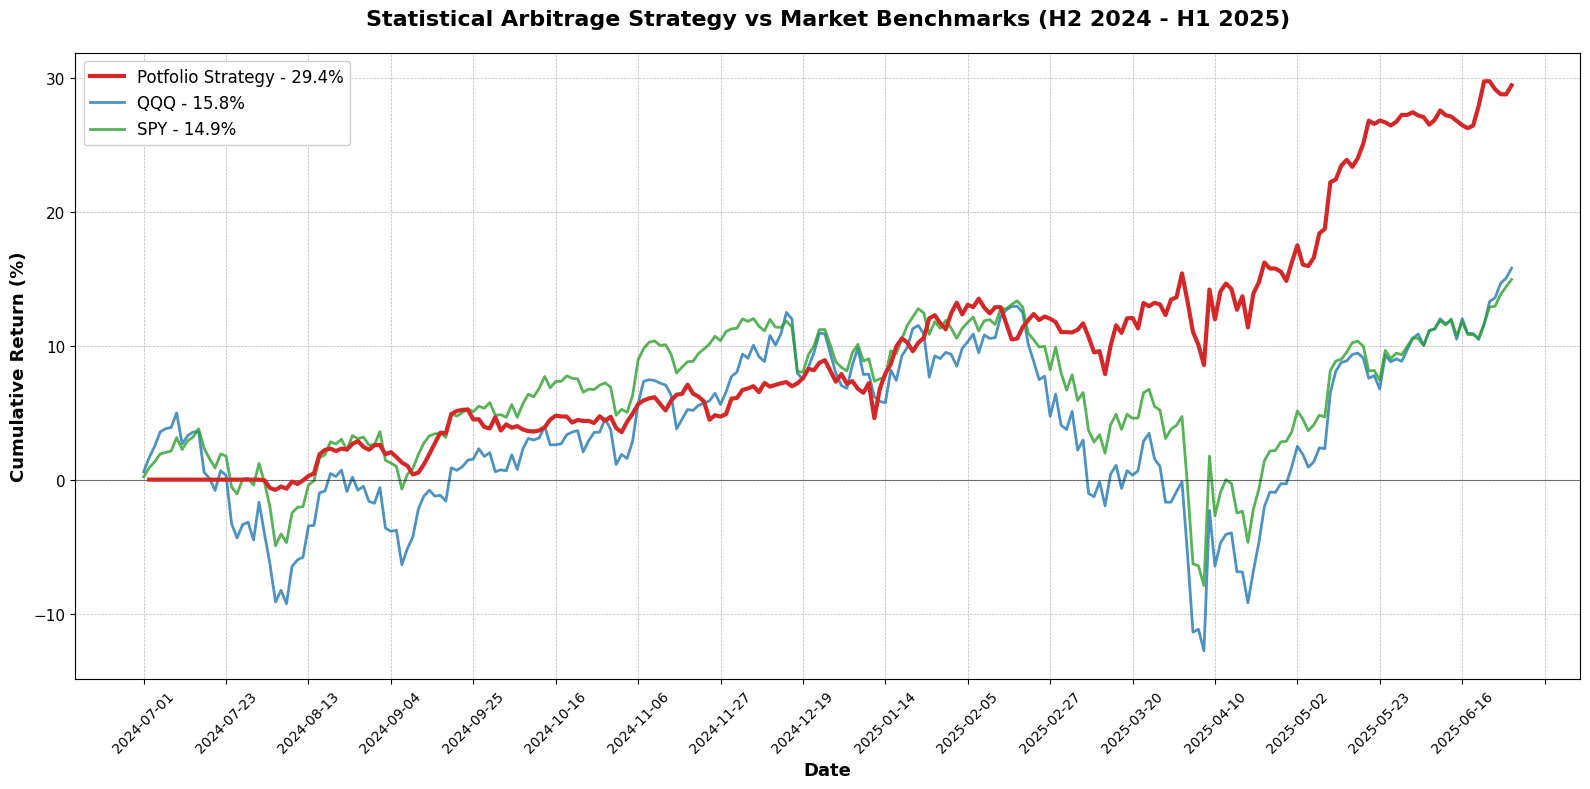

In [21]:
# Trim data to only show test period
strategy_returns_df = portfolio_returns[(portfolio_returns['Date'] >= '2024-07-01') & (portfolio_returns['Date'] <= '2025-06-30')]
benchmarks_df  = benchmarks_df[(benchmarks_df['Date'] >= '2024-07-01') & (benchmarks_df['Date'] <= '2025-06-30')]

qqq_df = benchmarks_df[benchmarks_df['Ticker'] == 'QQQ'].copy()
spy_df = benchmarks_df[benchmarks_df['Ticker'] == 'SPY'].copy()

# Compute cummulative returns for strategy and benchmarks
strategy_returns_df['Cumulative_Return'] = (1 + strategy_returns_df['Ret']).cumprod() - 1
qqq_df['Cumulative_Return'] = (1 + qqq_df['Ret']).cumprod() - 1
spy_df['Cumulative_Return'] = (1 + spy_df['Ret']).cumprod() - 1

# Add annotation for final values
final_strategy = strategy_returns_df['Cumulative_Return'].iloc[-1] * 100
final_spy = spy_df['Cumulative_Return'].iloc[-1] * 100
final_qqq = qqq_df['Cumulative_Return'].iloc[-1] * 100

fig, ax = plt.subplots(figsize=(16, 8))

# Plot with better styling
ax.plot(strategy_returns_df['Date'], strategy_returns_df['Cumulative_Return'] * 100, 
        linewidth=3, label=f'Potfolio Strategy - {final_strategy:.1f}%', color='#d62728', zorder=3)  # Red, on top
ax.plot(qqq_df['Date'], qqq_df['Cumulative_Return'] * 100, 
        linewidth=2, label=f'QQQ - {final_qqq:.1f}%', color='#1f77b4', alpha=0.8)  # Blue
ax.plot(spy_df['Date'], spy_df['Cumulative_Return'] * 100, 
        linewidth=2, label=f'SPY - {final_spy:.1f}%', color='#2ca02c', alpha=0.8)  # Green

# Add horizontal line at 0
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

# Formatting
ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Cumulative Return (%)', fontsize=13, fontweight='bold')
ax.set_title('Statistical Arbitrage Strategy vs Market Benchmarks (H2 2024 - H1 2025)', 
             fontsize=16, fontweight='bold', pad=20)

# Legend
ax.legend(loc='upper left', fontsize=12, framealpha=0.95)

# Grid
ax.grid(True, alpha=0.9, linestyle='--', linewidth=0.5)

# Format x-axis dates
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)
plt.yticks(fontsize=11)
plt.tight_layout()
# Save the figure
plt.savefig(PROJECT_ROOT / './results/cumulative_returns_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
# Add a label to each
spy_metrics['asset'] = 'SPY'
qqq_metrics['asset'] = 'QQQ'
portfolio_metrics['asset'] = 'Portfolio'

# Combine
combined = pd.concat([spy_metrics, qqq_metrics, portfolio_metrics], ignore_index=True)

# Reorder columns (asset first)
cols = ['asset'] + [c for c in combined.columns if c != 'asset']
combined = combined[cols]

pivot = combined.pivot_table(index='period', columns='asset', values=['total_return', 'annualized_return', 'sharpe_ratio', 'volatility', 'max_drawdown'])
pivot.to_excel(PROJECT_ROOT / './results/performance_metrics.xlsx')
pivot

annualized_return                     max_drawdown  \
asset                       Portfolio       QQQ       SPY    Portfolio   
period                                                                   
1st Half Testing             0.161110  0.143036  0.171792    -0.024527   
2nd Half Testing             0.456841  0.176492  0.129011    -0.059309   
Full Testing Period          0.297060  0.159242  0.150716    -0.059309   

                                        sharpe_ratio                      \
asset                     QQQ       SPY    Portfolio       QQQ       SPY   
period                                                                     
1st Half Testing    -0.135577 -0.084056     1.762045  0.501407  0.922381   
2nd Half Testing    -0.227683 -0.187552     2.566795  0.447598  0.342938   
Full Testing Period -0.227683 -0.187552     2.075409  0.461471  0.533701   

                    total_return                     volatility            \
asset                  Portfolio       QQQ       SPY  Portfolio       QQQ   
period                                                                      
1st Half Testing        0.078826  0.070263  0.083856   0.068165  0.203499   
2nd Half Testing        0.199809  0.081867  0.060505   0.162008  0.302710   
Full Testing Period     0.294386  0.157883  0.149435   0.123378  0.256229   

                               
asset                     SPY  
period                         
1st Half Testing     0.141798  
2nd Half Testing     0.256639  
Full Testing Period  0.205576